In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys
import time
import math
from PIL import Image
from skimage import io, transform
import cv2 as cv
from tqdm import tqdm
import shutil
import imutils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.dataset import Dataset # For custom datasets
import torchvision.utils as vutils
import torchvision
from torchvision import datasets, transforms,models 

%load_ext autoreload
%autoreload 2

In [2]:
path = 'C:/Users/done-/Desktop/squares_image_colorization'
len(os.listdir(path))

4751

### Create train and validation sets

In [3]:
np.random.seed(456)  #Set seed to maintain the same sampling
valid_files = list(np.random.choice(os.listdir(path), 100))
valid_files_set = set(valid_files)
train_files = []
[train_files.append(file) for file in os.listdir(path) if file not in valid_files_set]
print('Training: {} samples\tValidation: {} samples'.format(len(train_files), len(valid_files)))

Training: 4651 samples	Validation: 100 samples


### Data Loader

In [4]:
class load_data(Dataset):
    def __init__(self, root_dir, files_names, transform=None):
        
        self.root_dir = root_dir 
        self.files = files_names
        self.transform = transform

    def __len__(self):
        
        return len(self.files)

    def __getitem__(self, idx):
        
        nameimg = self.files[idx]
        img = io.imread(self.root_dir + '/' + nameimg)        
        sample = {'image': img}

        if self.transform:
            image_t = self.transform(sample["image"])
            sample = {'image': image_t}

        return sample

In [5]:
transf = transforms.Compose([transforms.ToPILImage(),
                             transforms.RandomApply(
                             [transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0),
                             transforms.RandomHorizontalFlip(p=1),
                             transforms.RandomRotation(10),
                             transforms.RandomPerspective(distortion_scale=0.15, p=1)], p=0.5),
                             transforms.Resize(128),
                             transforms.CenterCrop(128),
                             transforms.ToTensor(),
                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [6]:
transf_val = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(128),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [7]:
train_loader = torch.utils.data.DataLoader(load_data(path, train_files, transform=transf), batch_size=256)

In [8]:
len(train_loader)

19

In [9]:
valid_loader = torch.utils.data.DataLoader(load_data(path, valid_files, transform=transf_val), batch_size=32)

In [10]:
len(valid_loader)

4

Show some examples

In [11]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


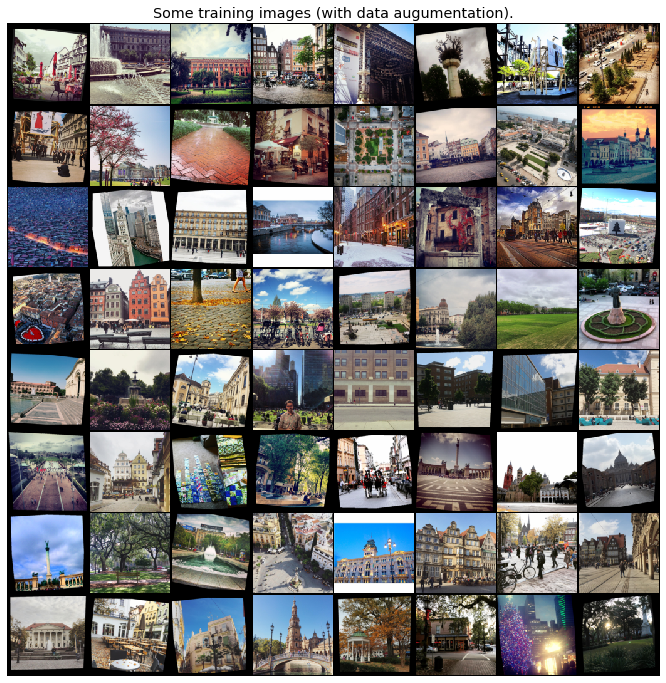

In [12]:
some_train_img = next(iter(train_loader))
plt.figure(figsize=(12,12))
plt.title('Some training images (with data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_train_img['image'].to(device)[:64], 
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

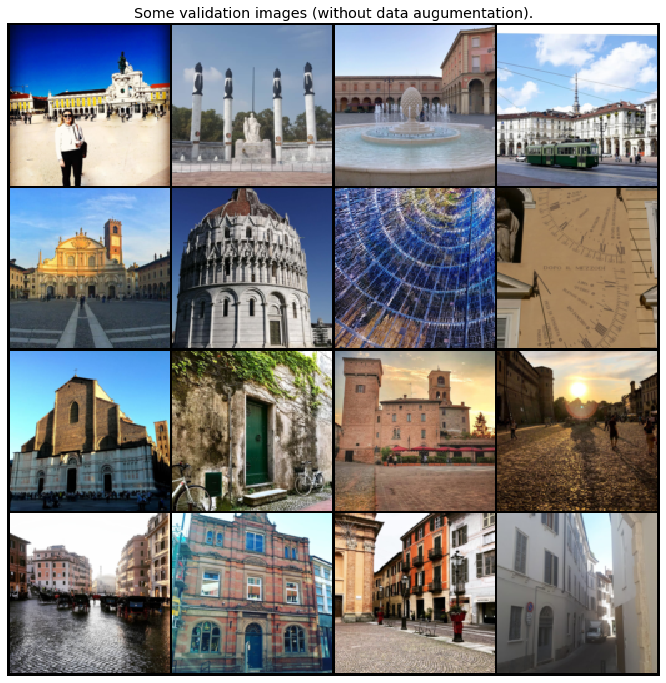

In [15]:
some_val_img = next(iter(valid_loader))
plt.figure(figsize=(12,12))
plt.title('Some validation images (without data augumentation).', fontsize='x-large')
plt.imshow(np.transpose(vutils.make_grid(some_val_img['image'].to(device)[:16], nrow=4,
                                         padding=2, normalize=True).cpu(), (1,2,0)))
plt.axis('off')
plt.show()

### Define AutoEncoder

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #Encoding layers
        self.conv1 = nn.Conv2d(1, 16, (3,3), stride=1, padding=1)  #out 16x128x128
        self.conv2 = nn.Conv2d(16, 32, (5,5), stride=1, padding=0) #out 32x124x124
        self.conv3 = nn.Conv2d(32, 64, (4,4), stride=2, padding=1) #out 64x62x62
        self.conv4 = nn.Conv2d(64, 128, (2,2), stride=2, padding=1) #out 128x32x32
        self.conv5 = nn.Conv2d(128, 512, (4,4), stride=2, padding=1) #out 512x16x16
        self.conv6 = nn.Conv2d(512, 1024, (4,4), stride=2, padding=1) #out 1024x8x8
        self.linear_enc = nn.Linear(1024*8*8, 1024*10)
        
        #Decoding layers
        self.linear_dec = nn.Linear(1024*10, 1024*8*8)
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), stride=2, padding=1) #512x16x16
        self.deconv2 = nn.ConvTranspose2d(512, 128, (4,4), stride=2, padding=1)  #128x32x32
        self.deconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride=2, padding=1)   #64x62x62
        self.deconv4 = nn.ConvTranspose2d(64, 32, (4,4), stride=2, padding=1)    #32x124x124
        self.deconv5 = nn.ConvTranspose2d(32, 16, (5,5), stride=1, padding=0)    #16x128x128
        self.deconv6 = nn.ConvTranspose2d(16, 3, (3,3), stride=1, padding=1)     #3x128x128
        
    def Encoder(self, x):
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(16)(self.conv1(x)))
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(32)(self.conv2(x)))
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(64)(self.conv3(x)))
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(128)(self.conv4(x)))
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(512)(self.conv5(x)))
        x = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm2d(1024)(self.conv6(x)))
        x = x.view(x.size()[0], 1024*8*8)
        z = nn.LeakyReLU(negative_slope=0.1)(nn.BatchNorm1d(1024*10)(self.linear_enc(x)))
        return z
    
    def Decoder(self, z):
        x = nn.ReLU()(nn.BatchNorm1d(1024*8*8)(self.linear_dec(z)))
        x = x.view(x.size()[0], 1024, 8, 8)
        x = nn.ReLU()(nn.BatchNorm2d(512)(self.deconv1(x)))
        x = nn.ReLU()(nn.BatchNorm2d(128)(self.deconv2(x)))
        x = nn.ReLU()(nn.BatchNorm2d(64)(self.deconv3(x)))
        x = nn.ReLU()(nn.BatchNorm2d(32)(self.deconv4(x)))
        x = nn.ReLU()(nn.BatchNorm2d(16)(self.deconv5(x)))
        out = nn.Tanh()(self.deconv6(x))
        return out

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

In [13]:
autoencoder = AutoEncoder().to(device)
summary(autoencoder, (1, 128, 128))

RuntimeError: CUDA out of memory. Tried to allocate 2.50 GiB (GPU 0; 4.00 GiB total capacity; 2.54 GiB already allocated; 582.39 MiB free; 17.65 MiB cached)